Домашнее задание

  Обучить генератор создавать точки, которые будут лежать на графике функции
  - y=sin(x)/x − x/10
  
  При выполнении данного задания структура GAN остается той же, но Вам нужно:

    - Сгенерировать настоящие данные
    - Изменить архитектуру дискриминатора и генератора
    - Построить графики


In [36]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

In [37]:
def my_func(x):
    return (np.sin(x)/x) - (x/10)

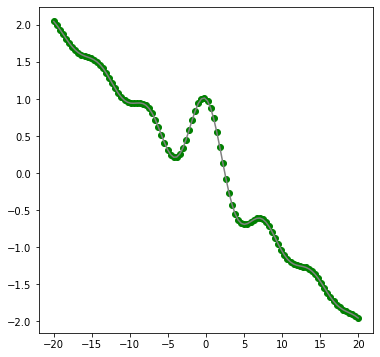

In [38]:
# визуализация графика функции

fig, ax = plt.subplots(figsize=(6, 6))
x = np.linspace(-20, 20, 100)
ax.scatter(x, y = my_func(x), color='green')
plt.plot(x, my_func(x), color='gray')
plt.show()

In [39]:
#генератор точек для датасета
def point_gen(ax, n):
    points = pd.DataFrame([(x, my_func(x)) for x in np.random.uniform(-ax, ax, size=(1, n))[0]], columns=['x', 'y'])
    return points

In [40]:
df_train = point_gen(10, 300000)
df_train

,x,y
0,-3.933106,0.212431
1,-0.051173,1.004681
2,9.421241,-0.941749
3,-5.198718,0.349819
4,6.603856,-0.612655
...,...,...
299995,4.472267,-0.664412
299996,-2.054414,0.636376
299997,-9.162895,0.944545
299998,0.982927,0.748285


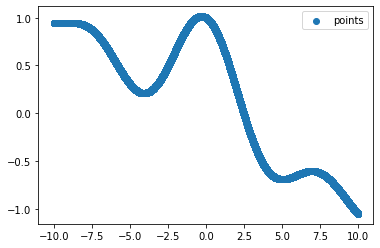

In [41]:
x,y = df_train.values.T
plt.scatter(x,y,label='points')
plt.legend()
plt.show()

In [42]:
#проведем нормализацию
scaler = MinMaxScaler()
data_train = scaler.fit_transform(df_train)  
data_train = torch.FloatTensor(data_train).float()
data_train

tensor([[0.3033, 0.6122],
        [0.4974, 0.9950],
        [0.9711, 0.0544],
        ...,
        [0.0419, 0.9659],
        [0.5491, 0.8711],
        [0.7948, 0.1937]])

In [43]:
class DatasetClass(torch.utils.data.Dataset):
   
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        point = self._data[idx] 
       
        return point

In [44]:
train_dataset = DatasetClass(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=256,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [46]:
discriminator = Discriminator()

In [47]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [48]:
generator = Generator()

In [49]:
lr = 0.001
num_epochs = 50
batch_size = 256
loss_function = nn.BCELoss()

In [50]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [51]:
%%time

for epoch in range(num_epochs):
    for n, real_samples in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6457268595695496
Epoch: 0 Loss G.: 0.8238813877105713
Epoch: 10 Loss D.: 0.6792963147163391
Epoch: 10 Loss G.: 0.7649068832397461
Epoch: 20 Loss D.: 0.6719476580619812
Epoch: 20 Loss G.: 0.7286472916603088
Epoch: 30 Loss D.: 0.6826181411743164
Epoch: 30 Loss G.: 0.7310627102851868
Epoch: 40 Loss D.: 0.6859092712402344
Epoch: 40 Loss G.: 0.7616922855377197
CPU times: user 10min 32s, sys: 5.56 s, total: 10min 38s
Wall time: 10min 37s


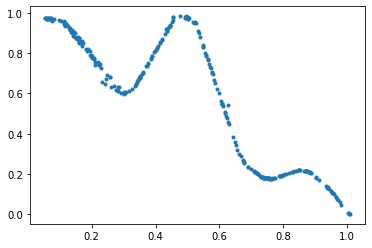

In [52]:
latent_space_samples = torch.randn(300, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")